<a href="https://colab.research.google.com/github/nikitaoltyan/ML-Homework/blob/main/Assignment4/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 4.1 - Сверточные нейронные сети (Convolutional Neural Networks)

Это последнее задание на numpy, вы до него дожили! Остался последний марш-бросок, дальше только PyTorch.

В этом задании вы реализуете свою собственную сверточную нейронную сеть.

In [2]:
# Запустите эту ячейку если работаете в Colab
import os
if not os.path.exists('CNN.ipynb'):
    !git clone https://github.com/nikitaoltyan/ML-Homework.git
%cd ML-Homework/Assignment4

Cloning into 'ML-Homework'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 349 (delta 32), reused 0 (delta 0), pack-reused 277
Receiving objects: 100% (349/349), 1.55 MiB | 16.85 MiB/s, done.
Resolving deltas: 100% (148/148), done.
/content/ML-Homework/Assignment4


In [3]:
! wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
%cd ../Assignment4

--2021-03-21 11:49:29--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  27.0MB/s    in 9.6s    

2021-03-21 11:49:39 (18.0 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-03-21 11:49:39--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  39.6MB/s    in 1.5s    

2021-03-21 11:49:41 (39.6 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-03-21 11:49:41--
Total wall clock time: 11s
Downloaded: 2 files, 235M in

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [5]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer, ConvolutionalLayer, MaxPoolingLayer, Flattener
from model import ConvNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

На этот раз мы не будем их преобразовывать в один вектор, а оставим размерности (num_samples, 32, 32, 3).

In [6]:
def prepare_for_neural_network(train_X, test_X):    
    train_X = train_X.astype(np.float) / 255.0
    test_X = test_X.astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_X, axis = 0)
    train_X -= mean_image
    test_X -= mean_image
    
    return train_X, test_X
    
train_X, train_y, test_X, test_y = load_svhn("", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

## Линейная свертка последовательностей

Для начала вспомним, что сверткой последовательностей называется такая последовательность, в которой каждый элемент есть сумма перемноженных элементов двух числовых последовательностей $x$ длиной $N_1$ и $h$ длиной $N_2$ таким образом, что члены одной последовательности берутся с возрастанием индексов, а члены другой — с убыванием.

$y_n = \sum\limits_{m=0}^n h_m \cdot x_{n-m}$

Такой же результат получится, если одну из последовательностей не сдвигать, а дополнить нулями с двух сторон.  
Заметим, что для более "похожих" последовательностей значения свертки будут больше.

<img src="https://github.com/balezz/tad_ml_dl_2021/blob/main/Assignment4/img/conv1D.jpg?raw=1">

## Двумерная свертка и max pooling


Пусть мы имеем матрицу черно-белого изображения размером $6x6x1$. Нам нужно определить какая фигура на нем изображена: горизонтальная или вертикальная? Для этого мы используем два сверточных фильтра (Convolution Filters, kernels) размером $3x3$. На первом фильтре у нас три пикселя, расположенных вертикально, на втором фильтре три пикселя, расположенных горизонтально.  


<img src="https://github.com/balezz/tad_ml_dl_2021/blob/main/Assignment4/img/conv2D_maxPool.jpg?raw=1">

Сдвигая выбранный регион вдоль оси x и оси y мы получаем новую матрицу (карту) размером $4x4$ со значениями скалярного произведения сверточного фильтра и выбранного региона. Т.к. фильтра у нас два, то и сверточных карт у нас тоже будет две: $4x4x2$.  

Далее, чтобы вычислить, на какой из фильтров больше "похоже" наше исходное изображение, применим операцию Max Pooling. Её смысл довольно прост - нужно из выбранного региона выбрать максимальное значение и записать его в выходную матрицу. Регионы так же как и в свертке сдвигаются вдоль оси x и y.  

В результате получаем тензор $3x3x2$, который подается на вход полносвязного слоя, на выходе которого будет два скаляра - z-score для каждого класса. Для первого класса score будет выше, что говорит о том, что исходное изображение является скорее всего вертикальной полосой, чем горизонтальной.   

Заметим, что в результате свертки у нас уменьшился размер исходного изображения. В общем случае это недопустимо, поэтому исходное изображение дополняется по краям (padding) значениями 0 или ближайших пикселей.

<img src="https://github.com/balezz/tad_ml_dl_2021/blob/main/Assignment4/img/conv.gif?raw=1">

# Реализуем новые слои!

Сначала основной новый слой - сверточный (Convolutional layer). 

На рисунке зеленым цветом обозначен один такой "регион", который скалярно перемножается с фильтром 1 (вертикальная полоска) и фильтром 2 (горизонтальная полоска).

<img src="https://github.com/balezz/tad_ml_dl_2021/blob/main/Assignment4/img/conv1.png?raw=1">

Он получает на вход   
регион входа I размера `(batch_size, filter_size, filter_size, input_channels)`,  
применяет к нему веса W `(filter_size, filter_size, input_channels, output_channels`
и выдает `(batch_size, output_channels)`. 

Если:  
- вход преобразовать в I' `(batch_size, filter_size*filter_size*input_channels)`,  
- веса в W' `(filter_size*filter_size*input_channels, output_channels)`,  
то выход "пикселе" будет эквивалентен полносвязному слою со входом I' и весами W'.

Осталось выполнить его в цикле для каждого пикселя :)

In [7]:
# TODO: Implement ConvolutionaLayer that supports only 1 output and input channel

# Note: now you're working with images, so X is 4-dimensional tensor of
# (batch_size, height, width, channels)

X = np.array([
              [
               [[1.0], [2.0]],
               [[0.0], [-1.0]]
              ]
              ,
              [
               [[0.0], [1.0]],
               [[-2.0], [-1.0]]
              ]
             ])

# Batch of 2 images of dimensions 2x2 with a single channel
print("Shape of X:",X.shape)

layer = ConvolutionalLayer(in_channels=1, out_channels=1, filter_size=2, padding=0)
print("Shape of W", layer.W.value.shape)
layer.W.value = np.zeros_like(layer.W.value)
layer.W.value[0, 0, 0, 0] = 1.0
layer.B.value = np.ones_like(layer.B.value)
result = layer.forward(X)

assert result.shape == (2, 1, 1, 1)
assert np.all(result == X[:, :1, :1, :1] +1), f"result: {result}, X: {X[:, :1, :1, :1]}"


# Now let's implement multiple output channels
layer = ConvolutionalLayer(in_channels=1, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)


# And now multple input channels!
X = np.array([[
               [[1.0, 0.0], [2.0, 1.0]],
               [[0.0, -1.0], [-1.0, -2.0]]
              ],[
               [[0.0, 1.0], [1.0, -1.0]],
               [[-2.0, 2.0], [-1.0, 0.0]]
              ]])

print("Shape of X:", X.shape)
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)

print(f'Result: {result}')

Shape of X: (2, 2, 2, 1)
Shape of W (2, 2, 1, 1)
Shape of X: (2, 2, 2, 2)
Result: [[[[-1.51381082 -1.9461965 ]]]


 [[[-4.89786213 -0.5934435 ]]]]


## А теперь имплементируем обратный проход
Возможно, это самое сложное место в курсе. Дальше будет лучше.

Раз выполнение сверточного слоя эквивалентно Fully Conected Layer для каждого "пикселя" выхода, то общий обратный проход эквивалентен обратному проходу каждого из таких "слоев".  
Градиенты от каждого из этих "слоев" в каждом пикселе надо сложить в соответствующие пиксели градиента по входу, а градиенты весов сложить все вместе.

In [11]:
# First test - check the shape is right
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape

# Actually test the backward pass
# As usual, you'll need to copy gradient check code from the previous assignment
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_gradient(layer, X)

layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'W')
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'B')

0.5913911931861932 0.5913911931720861
0.3846197258814826 0.3846197258905448
-0.7885612197803287 -0.7885612197888746
0.4264766505467265 0.4264766505501782
-0.9048785615098869 -0.9048785615251019
-0.9049150325095674 -0.9049150325290966
0.2836167895812308 0.28361678958699343
-0.6466106046850061 -0.6466106046820741
0.8656119944970345 0.8656119944938644
0.6199290294763771 0.6199290294661708
0.023561810433032817 0.02356181042495464
-0.7663717216393693 -0.7663717216277454
0.1884499413469086 0.188449941340707
-0.5703685601313704 -0.5703685601377018
-0.18332904975981967 -0.18332904975215666
-0.04557455818315853 -0.04557455818288147
Gradient check passed!
0.07885180401717445 0.07885180401956404
-0.2840866529492499 -0.2840866529574271
-1.3239612465964041 -1.323961246613159
-0.9605207175890123 -0.9605207176299756
-1.166257638562055 -1.1662576385518264
-1.5286940234875122 -1.5286940235448296
1.4028130506135785 1.4028130506327228
0.6764340646397624 0.6764340646725486
2.6479224931928083 2.64792249320

Осталось реализовать дополнение нулями (padding).   
Достаточно дополнить входной тензор нулями по сторонам. Не забудьте учесть это при обратном проходе!

In [12]:
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
result = layer.forward(X)
# Note this kind of layer produces the same dimensions as input
assert result.shape == X.shape,"Result shape: %s - Expected shape %s" % (result.shape, X.shape)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_gradient(layer, X)

1.3102303210428747 1.3102303211276478
-0.20275525683521475 -0.2027552567618329
-0.3792332460123957 -0.3792332460506031
-2.025399998298943 -2.0253999982955406
-0.20918051164317597 -0.20918051157892134
0.2258167143141181 0.2258167143054379
0.5452208702654796 0.5452208702738659
-0.992176093750765 -0.9921760937281475
0.7733198877224854 0.7733198876813673
-2.274390833769655 -2.2743908338007657
0.8511261413443394 0.8511261414323456
-1.8188669429095832 -1.8188669428820246
-0.2859010456475009 -0.2859010456823796
-4.167305296029605 -4.1673052960877754
1.0089050969283355 1.0089050968886681
0.5511074103450475 0.5511074104180835
Gradient check passed!


## После следующего слоя вам уже будет все ни по чем - max pooling

Max Pooling - это слой, реализующий операцию максимума для каждого канала отдельно в окресности из `pool_size` "пикселей".

![image](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

И напомним что такое stride.  
Stride - это на сколько "пикселей" сдвигается окно на одном шаге.  
Вот здесь, например, stride = 2

![image.png](http://deeplearning.net/software/theano/_images/no_padding_strides.gif)

На практике, для max pooling значение stride часто равно pool size.

In [13]:
pool = MaxPoolingLayer(2, 2)
result = pool.forward(X)
assert result.shape == (2, 1, 1, 2)

assert check_layer_gradient(pool, X)

0.0 0.0
0.0 0.0
0.20859859899219693 0.20859859899413633
0.9682899998123814 0.9682899998031401
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
-0.10884190462414232 -0.1088419046335609
0.0 0.0
0.0 0.0
-1.066716626361869 -1.0667166263633732
0.0 0.0
0.0 0.0
Gradient check passed!


И на закуску - слой, преобразующий четырехмерные тензоры в двумерные.

Этот слой понадобится нам, чтобы в конце сети перейти от сверточных слоев к полносвязным.

In [14]:
flattener = Flattener()
result = flattener.forward(X)
assert result.shape == (2,8)

assert check_layer_gradient(flattener, X)

0.9041822469747064 0.9041822469413318
-1.0072605907201435 -1.0072605907573973
1.8088613778929445 1.8088613779276839
0.5607693490151672 0.5607693490006227
-0.5988927366153652 -0.5988927366473717
1.108651612506258 1.1086516125136114
-0.00918903403088564 -0.009189034022583087
-0.22140556099402312 -0.22140556099614625
-0.6808693760977649 -0.6808693760795846
-1.8781789995318374 -1.8781789995259144
0.6043925703668273 0.6043925703913544
-1.6281267618176072 -1.6281267618545312
-0.7932943318513783 -0.7932943318689211
0.43284455385027715 0.4328445538437364
-0.5006764014955146 -0.5006764014936493
0.15715187079094847 0.15715187076104087
Gradient check passed!


# Теперь есть все кирпичики, создаем модель

In [45]:
# TODO: In model.py, implement missed functions function for ConvNet model

# No need to use L2 regularization
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W1
-0.00036400342322493064 -0.00036400342739995034
0.00024199225737753924 0.00024199227066645787
-0.0006069930255196013 -0.0006069930114094291
0.0002676120760449786 0.0002676120658406944
-0.0010698712879900858 -0.00106987128045688
0.00031883952400761775 0.00031883953255373854
0.00018373059084115316 0.0001837305863006122
3.754675748496823e-05 3.7546765696561124e-05
-8.102364684826611e-05 -8.102363224793407e-05
6.73696519301973e-05 6.736966540188405e-05
-0.0005655446055273523 -0.0005655446111418883
0.00012878271391389878 0.00012878271782312822
-0.003383343150285762 -0.0033833431389851394
0.00023018100271880078 0.0002301810297922202
-0.0035234010266400975 -0.0035234010375972953
0.0002691036057107778 0.0002691036060653573
-0.0037328954276841563 -0.0037328954372028984
0.0003213377650134381 0.00032133777860821056
-0.0005474303932210363 -0.0005474303899077881
-0.00013358285589211682 -0.00013358285588793706
-0.0007832044608654779 -0.0007832044790490044
-8.050652140529289e

True

# Оптимизатор и код для тренировки 
Должен заработать с кодом из прошлого задания без изменений!

In [72]:
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
dataset = Dataset(train_X[:16], train_y[:16], val_X[:16], val_y[:16])
trainer = Trainer(model, dataset, SGD(), batch_size=16, learning_rate=1e-4)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.304112, Train accuracy: 0.062500, val accuracy: 0.187500
Loss: 2.303521, Train accuracy: 0.187500, val accuracy: 0.062500
Loss: 2.683572, Train accuracy: 0.250000, val accuracy: 0.062500
Loss: 2.911065, Train accuracy: 0.250000, val accuracy: 0.062500
Loss: 2.392876, Train accuracy: 0.312500, val accuracy: 0.062500
Loss: 2.228659, Train accuracy: 0.312500, val accuracy: 0.062500
Loss: 2.136964, Train accuracy: 0.312500, val accuracy: 0.062500
Loss: 2.075731, Train accuracy: 0.312500, val accuracy: 0.062500
Loss: 2.030937, Train accuracy: 0.312500, val accuracy: 0.062500
Loss: 1.996075, Train accuracy: 0.312500, val accuracy: 0.062500
Loss: 1.968828, Train accuracy: 0.437500, val accuracy: 0.062500
Loss: 1.947177, Train accuracy: 0.375000, val accuracy: 0.062500
Loss: 1.930280, Train accuracy: 0.375000, val accuracy: 0.062500
Loss: 1.916361, Train accuracy: 0.437500, val accuracy: 0.062500
Loss: 1.904843, Train accuracy: 0.312500, val accuracy: 0.062500
Loss: 1.895184, Train acc

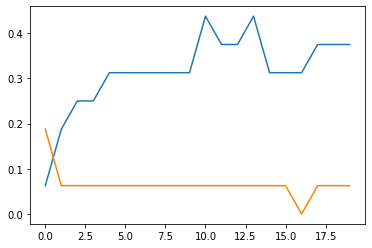

In [73]:
plt.plot(train_history)
plt.plot(val_history)

# Последнее упражнение
В качестве последнего упражнения мы доведем точность на тренировочном наборе данных до 100% на небольшом наборе данных.
Сверточные сети требуют большого количества вычислений и аккуратной эффективной реализации, поэтому настоящие модели мы будем тренировать уже на PyTorch в следующем задании.

## Итак, оверфитим маленький набор данных


In [82]:
data_size = 128
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=40, conv2_channels=40)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach 1.0 training accuracy in 50 epochs or less
# Hint: If you have hard time finding the right parameters manually, try grid search or random search!
trainer = Trainer(model, dataset, MomentumSGD(0.9), learning_rate=1e-3, learning_rate_decay=0.965, num_epochs=45, batch_size=8)

loss_history, train_history, val_history = trainer.fit()

Loss: 186.635442, Train accuracy: 0.117188, val accuracy: 0.085938
Loss: 32.474373, Train accuracy: 0.085938, val accuracy: 0.054688
Loss: 7.374327, Train accuracy: 0.156250, val accuracy: 0.101562
Loss: 3.191487, Train accuracy: 0.320312, val accuracy: 0.164062
Loss: 2.160402, Train accuracy: 0.359375, val accuracy: 0.132812
Loss: 2.324610, Train accuracy: 0.507812, val accuracy: 0.164062
Loss: 1.998458, Train accuracy: 0.507812, val accuracy: 0.210938
Loss: 1.049733, Train accuracy: 0.671875, val accuracy: 0.164062
Loss: 0.626256, Train accuracy: 0.757812, val accuracy: 0.156250
Loss: 0.432283, Train accuracy: 0.781250, val accuracy: 0.164062
Loss: 1.200475, Train accuracy: 0.796875, val accuracy: 0.171875
Loss: 1.250443, Train accuracy: 0.835938, val accuracy: 0.156250
Loss: 0.531170, Train accuracy: 0.851562, val accuracy: 0.179688
Loss: 0.568453, Train accuracy: 0.890625, val accuracy: 0.187500
Loss: 0.790816, Train accuracy: 0.921875, val accuracy: 0.148438
Loss: 1.067822, Train 

Best train accuracy: 1.0


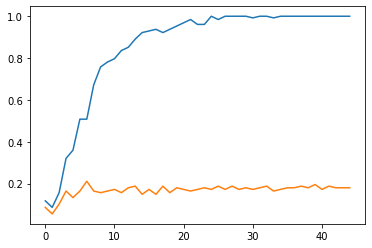

In [84]:
print(f"Best train accuracy: {max(train_history)}")
plt.plot(train_history)
plt.plot(val_history)